In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [514]:
from importlib import reload
import random
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import pytorch_lightning as pl
import skimage.morphology as morp
from pytorch_lightning import Trainer



import general.array_morphology as arm
import deep_morpho.models.pconv as pconv
import deep_morpho.models.lightning_pconv as lpconv
import deep_morpho.models.dilation_layer as dill
import deep_morpho.models.lightning_dilation_layer as ldill
import deep_morpho.datasets.generate_forms as gfo
import deep_morpho.datasets.multi_rect_dataset as mrda

def reload_modules():
    for modl in [arm, pconv, lpconv, dill, ldill, gfo, mrda]:
        reload(modl)
        
reload_modules()

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

cuda


In [367]:
def plot_horizontal(imgs):
    n_figs = len(imgs)
    fig = plt.figure(figsize=(5*n_figs, 5))
    for idx in range(1, n_figs + 1):
        ax = fig.add_subplot(1, n_figs, idx)
        ax.imshow(imgs[idx-1])


# Dataset

Done.


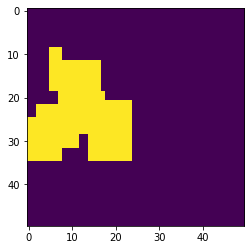

In [339]:
reload_modules()
x, rect_args = gfo.random_multi_rect(
    size=(50, 50), 
    n_rectangles=8,
    max_shape=(10, 10),
    return_rects=True, 
    first_rect_args={
        "top_left_x_props": (.3, .7),
        "top_left_y_props": (.3, .7)
    }
)
plt.imshow(x)


torch.Size([4, 1, 50, 50]) torch.Size([4, 50, 50])
CPU times: user 256 ms, sys: 798 µs, total: 257 ms
Wall time: 120 ms


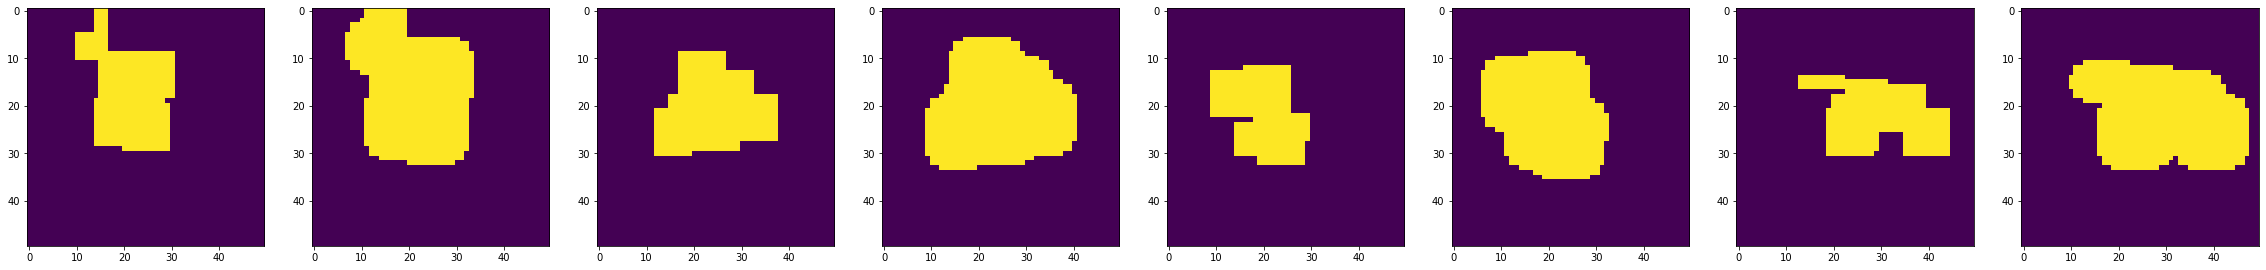

In [511]:
%%time
reload_modules()
dataset = mrda.MultiRectDataset(size=(50, 50), n_rectangles=8, max_shape=(10, 10), selem=morp.disk(3))
# input_, target = dataset[0]
dataloader = DataLoader(dataset, batch_size=4)

inputs, targets = next(iter(dataloader))
print(inputs.shape, targets.shape)

plot_horizontal(
    reduce(lambda a,b: a+b, 
           [[inpt[0].cpu(), target.cpu()] for (inpt, target) in zip(inputs, targets)]))

# Net

In [340]:
reload_modules()
mpc = dill.DilationLayer(in_channels=1, out_channels=1, kernel_size=(5, 5))


Done.


In [349]:
%%time
otp = mpc(torch.tensor(x[np.newaxis, ...]).float().unsqueeze(0))
target = arm.array_dilation(x, morp.disk(3))

CPU times: user 4.86 ms, sys: 0 ns, total: 4.86 ms
Wall time: 2.81 ms


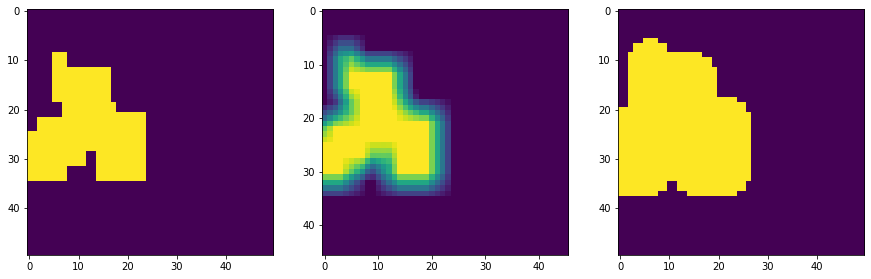

In [372]:
plot_horizontal([
    x,
    otp.detach()[0, 0],
    target
]);




# Training

In [562]:
reload_modules()
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

model = ldill.LightningDilationLayer(
    model_args={
        "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5)
    },
    learning_rate=1e-4,
    loss=loss,
    optimizer=optimizer,
    output_dir="deep_morpho/results"
)
model.to(device)

trainer = Trainer(
    max_epochs=1,
    gpus=1 if torch.cuda.is_available() else 0,
#     logger=logger,
    progress_bar_refresh_rate=10,
#     callbacks=[checkpoint_callback, stop_callback, obs.LogMetricsEpoch()]
)

dataloader = mrda.get_loader(batch_size=16, n_inputs=100000, size=(50, 50), n_rectangles=8,
                            device=device, max_shape=(10, 10))
trainer.fit(model, dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | DilationLayer     | 26    
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
26        Trainable params
0         Non-trainable params
26        Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

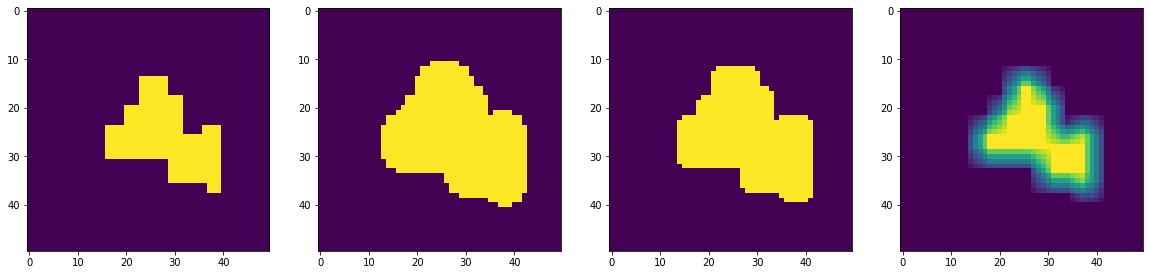

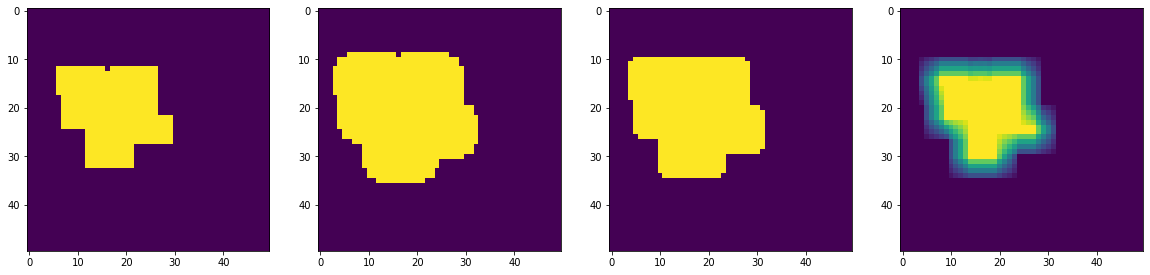

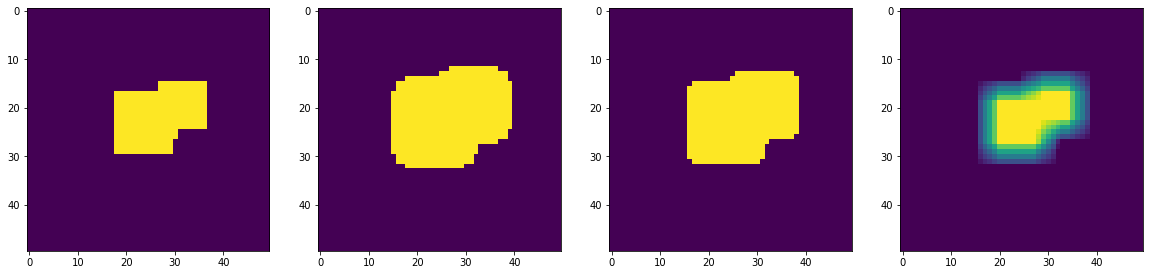

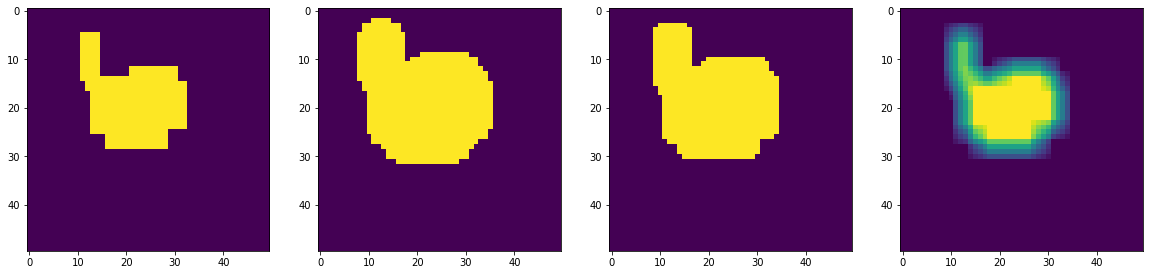

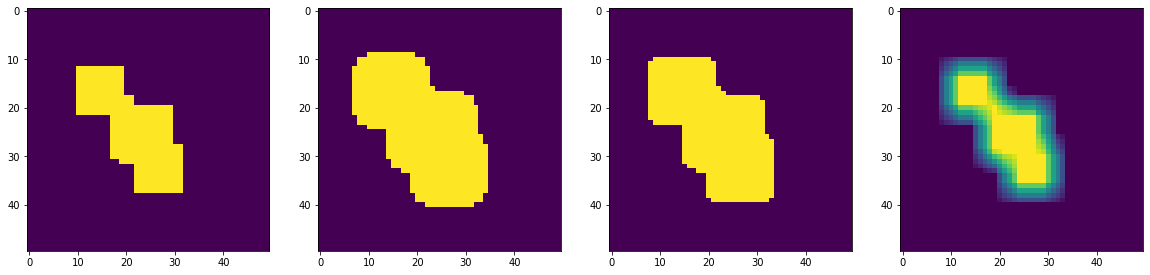

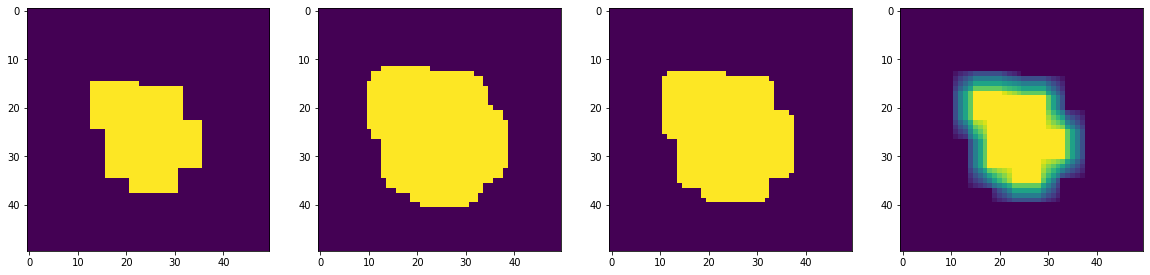

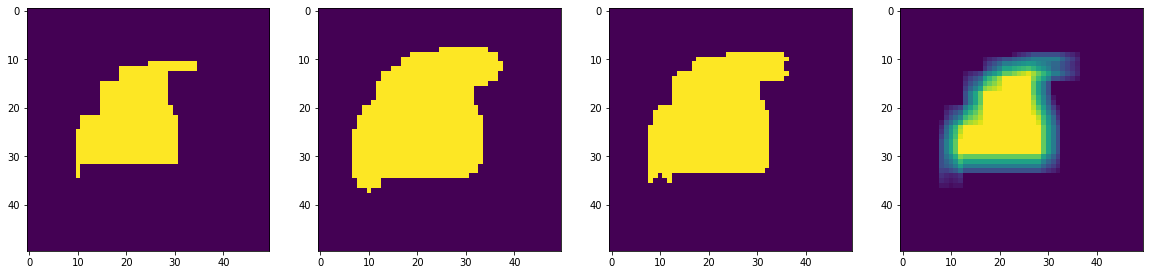

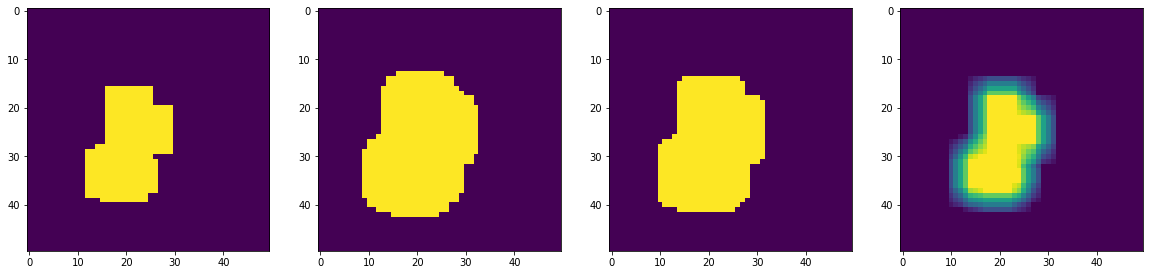

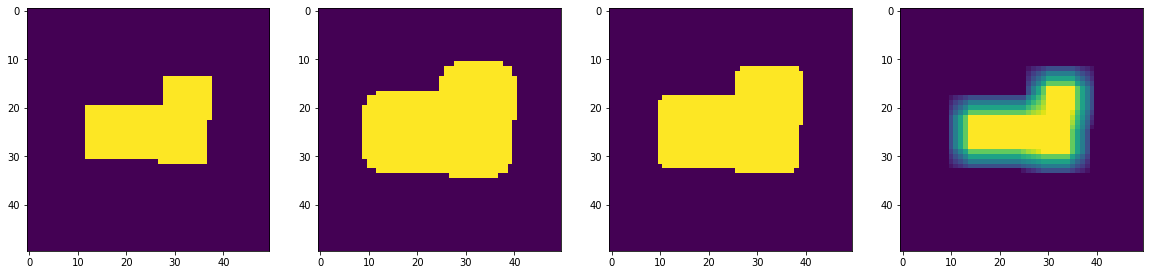

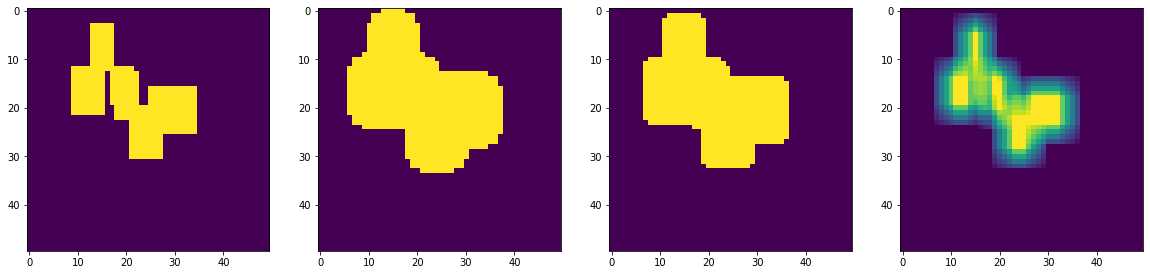

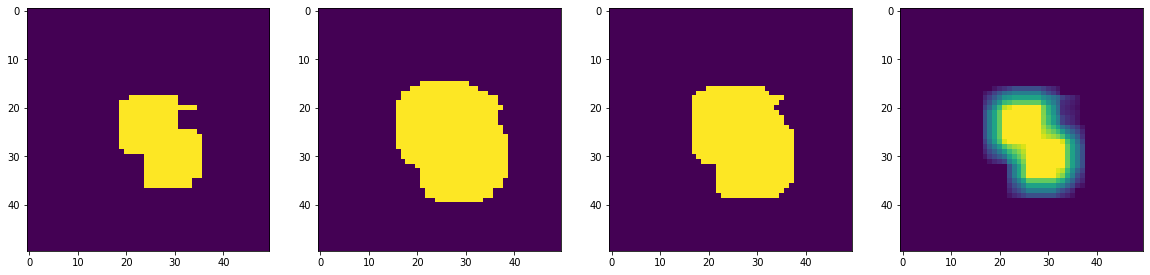

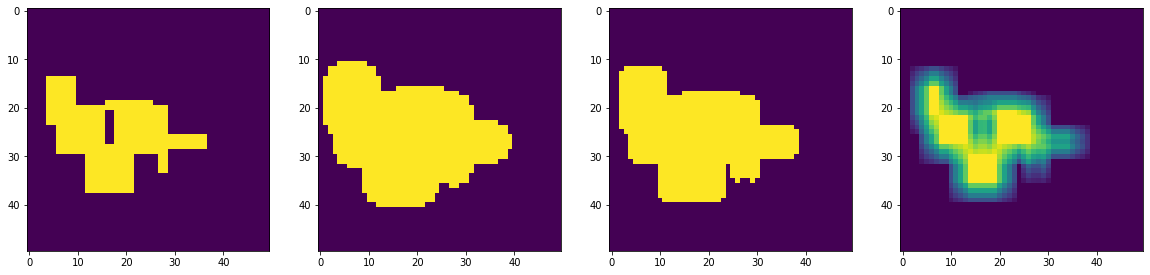

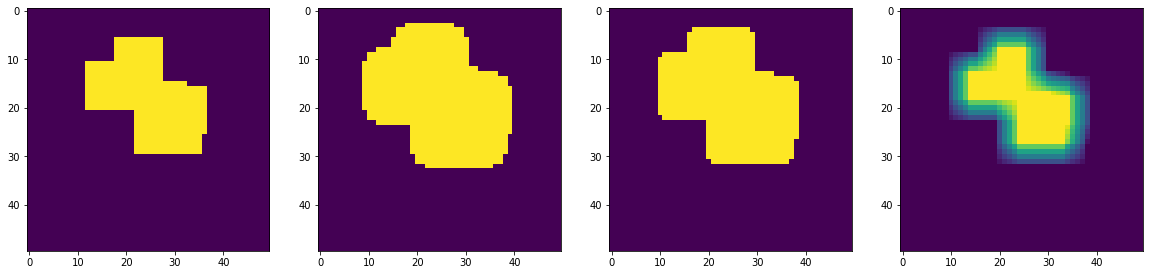

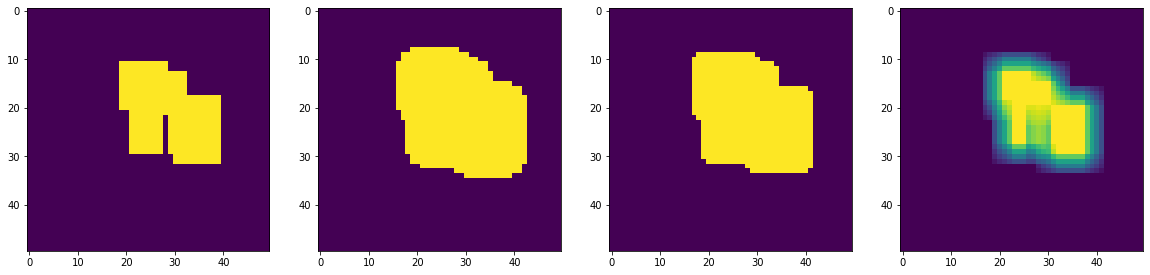

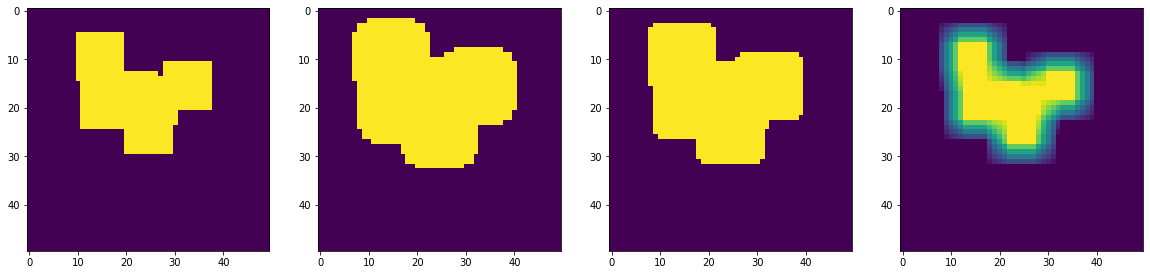

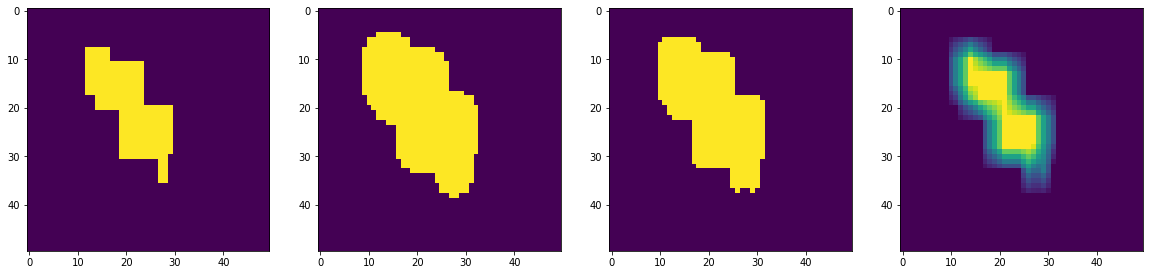

In [563]:
model.to(device)
inputs, targets = next(iter(dataloader))
outputs = model(inputs)
for idx in range(len(inputs)):
    plot_horizontal([tensor[idx].squeeze().cpu().detach() for tensor in [
        inputs, targets, outputs > .1, outputs]])

In [565]:
print(torch.sigmoid(model.model.conv.weight))

tensor([[[[0.6185, 0.6224, 0.4264, 0.6560, 0.6773],
          [0.6574, 0.3118, 0.3085, 0.3085, 0.6091],
          [0.4518, 0.3380, 0.3553, 0.3463, 0.4035],
          [0.5947, 0.3305, 0.3893, 0.3233, 0.6431],
          [0.6793, 0.5881, 0.3994, 0.6492, 0.6511]]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


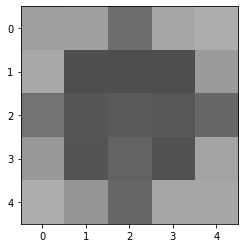

In [566]:
plt.imshow(torch.sigmoid(model.model.conv.weight).cpu().detach()[0, 0], cmap='gray',
          vmin=0, vmax=1)

In [556]:
list(model.named_parameters())

[('model.P_',
  Parameter containing:
  tensor([1.], device='cuda:0', requires_grad=True)),
 ('model.conv.weight',
  Parameter containing:
  tensor([[[[ 0.0349, -0.0340, -0.1408,  0.1551, -0.0622],
            [-0.0485,  0.1123, -0.0150,  0.1360, -0.0878],
            [-0.1224,  0.0408, -0.1071, -0.0983,  0.1559],
            [-0.1342, -0.0321, -0.2333, -0.1011,  0.0031],
            [ 0.0028, -0.1017, -0.0650, -0.1374, -0.1052]]]], device='cuda:0',
         requires_grad=True))]